# Collaborative filtering deep varianten
- Variant 1: baseline met sample of class weights
- Variant 2: variant 1 met meer dropout
- Variant 3: baseline met batch normalization

In [1]:
from functools import reduce
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dot, Concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

pd.set_option('display.max_columns', None)

def save(obj, path):
    with open(path, 'bw') as file:
        pickle.dump(obj, file)

def load(path):
    with open(path, 'br') as file:
        return pickle.load(file)

def missing(df):
    return df[df.isna().any(axis='columns')]

def chain_layers(*layers):
    return reduce(lambda output, layer: layer(output), layers)

def plot_loss(history):
    n_epoch = len(history['loss'])
    xs = np.arange(1, n_epoch + 1)
    fig, ax = plt.subplots()
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.plot(xs, history['loss'], label='Train')
    ax.plot(xs, history['val_loss'], label='Validation')
    ax.legend()
    return fig

def plot_acc(history):
    n_epoch = len(history['accuracy'])
    xs = np.arange(1, n_epoch + 1)
    fig, [loss, acc] = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    loss.set_ylabel('Loss')
    loss.plot(xs, history['loss'], label='Train')
    loss.plot(xs, history['val_loss'], label='Validation')
    acc.set_xlabel('Epoch')
    acc.set_ylabel('Accuracy')
    acc.plot(xs, history['accuracy'])
    acc.plot(xs, history['val_accuracy'])
    fig.legend()
    return fig

def print_rg_report(y, y_pred):
    print(f'MSE = {mean_squared_error(y, y_pred)}\nMAE = {mean_absolute_error(y, y_pred)}')

def plot_preds(y, y_pred):
    n_classes = len(np.unique(y))
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    ax.set_xlim(0, n_classes + 1)
    ax.set_xticks(np.arange(1, n_classes + 1))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.scatter(y, y_pred, s=64, alpha=1 / 256)
    return fig

def print_cl_report(y, y_pred):
    print(classification_report(y, y_pred))

def plot_rocc(y, Y_prob):
    n_classes = Y_prob.shape[1]
    first_class = (n_classes == 2 and 1) or 0
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.plot([0, 1], [0, 1], "--")
    for cl in range(first_class, n_classes):
        fpr, tpr, _ths = roc_curve(y, Y_prob[:, cl], pos_label=cl)
        ax.plot(fpr, tpr, label=f'{cl}, AUC = {auc(fpr, tpr):.2f}')
    ax.legend()
    return fig

def plot_confmat(y, y_pred):
    n_classes = len(np.unique(y))
    confmat = confusion_matrix(y, y_pred)
    max_v = confmat.max()
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    xys = np.arange(n_classes)
    ax.set_xticks(xys)
    ax.set_yticks(xys)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.imshow(confmat, vmin=max_v * -1, vmax=max_v, cmap='coolwarm')
    for actual in range(n_classes):
        for predicted in range(n_classes):
            ax.text(predicted, actual, confmat[actual, predicted], ha='center', va='center')
    return fig

In [2]:
movies = pd.read_parquet('data/movies_active.parquet')
ratings = pd.read_parquet('data/ratings_active.parquet')
users = pd.read_parquet('data/users_active.parquet')

In [3]:
n_classes = ratings['rating'].nunique()
user_dim, user_voc_size = (1,), users['user_id'].max()
movie_dim, movie_voc_size = (1,), movies['movie_id'].max()
X_train, X_test, y_train, y_test, Y_train = load('data/train_test_active.pickle')[3:]
sample_weights = compute_sample_weight('balanced', y_train)
class_weights = dict(zip(range(n_classes), compute_class_weight('balanced', sorted(y_train.unique()), y_train)))

# Regressie

## Variant 1

In [4]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(1)
)
movies_cf_r_d_1 = Model([user_input, movie_input], user_movie, name='movies_cf_r_d_1')
movies_cf_r_d_1.summary()

Model: "movies_cf_r_d_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [5]:
movies_cf_r_d_1.compile('adam', 'mse')
movies_cf_r_d_1_hist = movies_cf_r_d_1.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8,
    validation_split=0.2, sample_weight=sample_weights,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 50s 17ms/step - loss: 1.5072 - val_loss: 1.1747
Epoch 2/8
3011/3011 [==============================] - 52s 17ms/step - loss: 1.0012 - val_loss: 1.1422
Epoch 3/8
3011/3011 [==============================] - 51s 17ms/step - loss: 0.9301 - val_loss: 1.1509
Epoch 4/8
3011/3011 [==============================] - 52s 17ms/step - loss: 0.8741 - val_loss: 1.1340


In [6]:
movies_cf_r_d_1.save('data/movies_cf_r_d_1.h5')
save(movies_cf_r_d_1_hist.history, 'data/movies_cf_r_d_1_history.pickle')

### Evalueren

In [7]:
movies_cf_r_d_1 = load_model('data/movies_cf_r_d_1.h5')
movies_cf_r_d_1_history = load('data/movies_cf_r_d_1_history.pickle')

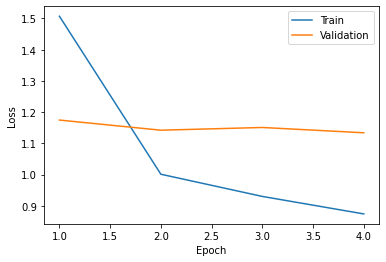

In [8]:
plot_loss(movies_cf_r_d_1_history);

In [9]:
y_movies_cf_r_d_1_test = movies_cf_r_d_1.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_d_1_train = movies_cf_r_d_1.predict([X_train['user_id'], X_train['movie_id']])

In [10]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_d_1_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_d_1_train)

Test:
MSE = 0.8286878869212486
MAE = 0.7089256108027289
Train:
MSE = 0.768951860767432
MAE = 0.6813116212310727


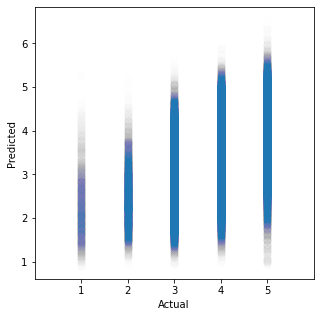

In [11]:
plot_preds(y_test, y_movies_cf_r_d_1_test);

## Variant 2

In [22]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.3),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.3),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.3),
    Dense(64, 'relu'),
    Dropout(0.3),
    Dense(1)
)
movies_cf_r_d_2 = Model([user_input, movie_input], user_movie, name='movies_cf_r_d_2')
movies_cf_r_d_2.summary()

Model: "movies_cf_r_d_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [23]:
movies_cf_r_d_2.compile('adam', 'mse')
movies_cf_r_d_2_hist = movies_cf_r_d_2.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8,
    validation_split=0.2, sample_weight=sample_weights,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 52s 17ms/step - loss: 1.7030 - val_loss: 1.1780
Epoch 2/8
3011/3011 [==============================] - 51s 17ms/step - loss: 1.1714 - val_loss: 1.1354
Epoch 3/8
3011/3011 [==============================] - 51s 17ms/step - loss: 1.0607 - val_loss: 1.1285
Epoch 4/8
3011/3011 [==============================] - 53s 18ms/step - loss: 1.0023 - val_loss: 1.1239


In [24]:
movies_cf_r_d_2.save('data/movies_cf_r_d_2.h5')
save(movies_cf_r_d_2_hist.history, 'data/movies_cf_r_d_2_history.pickle')

### Evalueren

In [25]:
movies_cf_r_d_2 = load_model('data/movies_cf_r_d_2.h5')
movies_cf_r_d_2_history = load('data/movies_cf_r_d_2_history.pickle')

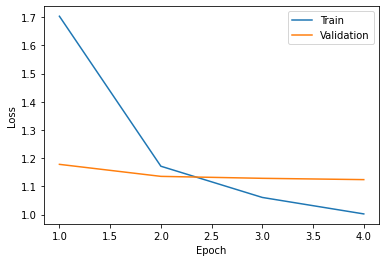

In [26]:
plot_loss(movies_cf_r_d_2_history);

In [27]:
y_movies_cf_r_d_2_test = movies_cf_r_d_2.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_d_2_train = movies_cf_r_d_2.predict([X_train['user_id'], X_train['movie_id']])

In [28]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_d_2_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_d_2_train)

Test:
MSE = 0.9205688642176139
MAE = 0.760796913196846
Train:
MSE = 0.8640708477181295
MAE = 0.7366917111946791


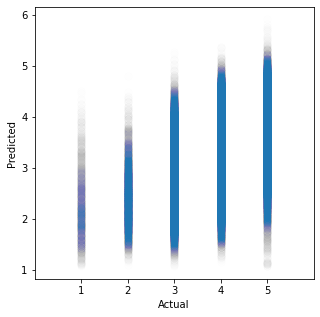

In [29]:
plot_preds(y_test, y_movies_cf_r_d_2_test);

## Variant 3

In [4]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(1)
)
movies_cf_r_d_3 = Model([user_input, movie_input], user_movie, name='movies_cf_r_d_3')
movies_cf_r_d_3.summary()

Model: "movies_cf_r_d_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [5]:
movies_cf_r_d_3.compile('adam', 'mse')
movies_cf_r_d_3_hist = movies_cf_r_d_3.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 47s 16ms/step - loss: 1.0395 - val_loss: 0.4953
Epoch 2/8
3011/3011 [==============================] - 48s 16ms/step - loss: 0.4567 - val_loss: 0.4670
Epoch 3/8
3011/3011 [==============================] - 47s 16ms/step - loss: 0.4245 - val_loss: 0.4598
Epoch 4/8
3011/3011 [==============================] - 46s 15ms/step - loss: 0.4007 - val_loss: 0.4563


In [6]:
movies_cf_r_d_3.save('data/movies_cf_r_d_3.h5')
save(movies_cf_r_d_3_hist.history, 'data/movies_cf_r_d_3_history.pickle')

### Evalueren

In [7]:
movies_cf_r_d_3 = load_model('data/movies_cf_r_d_3.h5')
movies_cf_r_d_3_history = load('data/movies_cf_r_d_3_history.pickle')

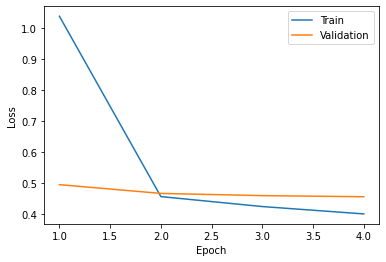

In [8]:
plot_loss(movies_cf_r_d_3_history);

In [9]:
y_movies_cf_r_d_3_test = movies_cf_r_d_3.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_d_3_train = movies_cf_r_d_3.predict([X_train['user_id'], X_train['movie_id']])

In [10]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_d_3_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_d_3_train)

Test:
MSE = 0.49371402604030123
MAE = 0.5437920242452401
Train:
MSE = 0.45055492083003523
MAE = 0.5162809001560942


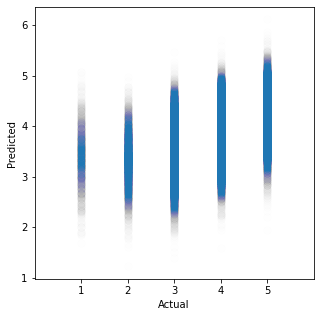

In [11]:
plot_preds(y_test, y_movies_cf_r_d_3_test);

# Classificatie

## Variant 1

In [12]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(n_classes, 'softmax')
)
movies_cf_c_d_1 = Model([user_input, movie_input], user_movie, name='movies_cf_c_d_1')
movies_cf_c_d_1.summary()

Model: "movies_cf_c_d_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [13]:
movies_cf_c_d_1.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_d_1_hist = movies_cf_c_d_1.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8,
    validation_split=0.2, class_weight=class_weights,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 48s 16ms/step - loss: 1.3137 - accuracy: 0.4141 - val_loss: 1.1870 - val_accuracy: 0.4829
Epoch 2/8
3011/3011 [==============================] - 48s 16ms/step - loss: 1.0895 - accuracy: 0.4874 - val_loss: 1.1306 - val_accuracy: 0.4981
Epoch 3/8
3011/3011 [==============================] - 47s 16ms/step - loss: 0.9864 - accuracy: 0.5074 - val_loss: 1.1652 - val_accuracy: 0.4878
Epoch 4/8
3011/3011 [==============================] - 47s 16ms/step - loss: 0.9179 - accuracy: 0.5185 - val_loss: 1.1573 - val_accuracy: 0.4873
Epoch 5/8
3011/3011 [==============================] - 48s 16ms/step - loss: 0.8708 - accuracy: 0.5301 - val_loss: 1.2068 - val_accuracy: 0.4580


In [14]:
movies_cf_c_d_1.save('data/movies_cf_c_d_1.h5')
save(movies_cf_c_d_1_hist.history, 'data/movies_cf_c_d_1_history.pickle')

### Evalueren

In [15]:
movies_cf_c_d_1 = load_model('data/movies_cf_c_d_1.h5')
movies_cf_c_d_1_history = load('data/movies_cf_c_d_1_history.pickle')

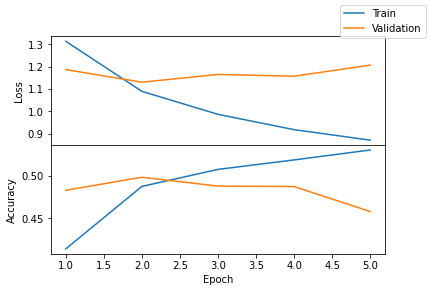

In [16]:
plot_acc(movies_cf_c_d_1_history);

In [17]:
Y_movies_cf_c_d_1_test = movies_cf_c_d_1.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_d_1_test = Y_movies_cf_c_d_1_test.argmax(axis=1)
Y_movies_cf_c_d_1_train = movies_cf_c_d_1.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_d_1_train = Y_movies_cf_c_d_1_train.argmax(axis=1)

In [18]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_d_1_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_d_1_train)

Test:
              precision    recall  f1-score   support

           0       0.07      0.50      0.12      1646
           1       0.13      0.38      0.19      4616
           2       0.50      0.49      0.50     42436
           3       0.68      0.43      0.53     77496
           4       0.52      0.66      0.58     34373

    accuracy                           0.50    160567
   macro avg       0.38      0.49      0.38    160567
weighted avg       0.57      0.50      0.52    160567

Train:
              precision    recall  f1-score   support

           0       0.12      0.76      0.20      4940
           1       0.19      0.55      0.28     13846
           2       0.54      0.54      0.54    127306
           3       0.71      0.46      0.56    232487
           4       0.55      0.70      0.61    103119

    accuracy                           0.54    481698
   macro avg       0.42      0.60      0.44    481698
weighted avg       0.61      0.54      0.56    481698



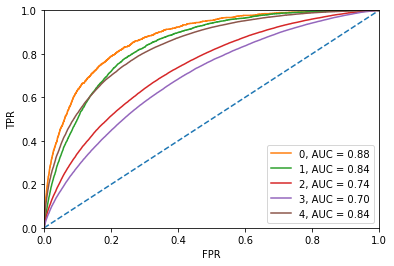

In [19]:
plot_rocc(y_test - 1, Y_movies_cf_c_d_1_test);

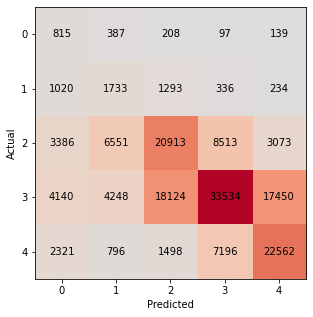

In [20]:
plot_confmat(y_test - 1, y_movies_cf_c_d_1_test);

In [21]:
print_rg_report(y_test - 1, y_movies_cf_c_d_1_test)

MSE = 1.2349548786487883
MAE = 0.6954916016367


## Variant 2

In [30]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.3),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.3),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.3),
    Dense(64, 'relu'),
    Dropout(0.3),
    Dense(n_classes, 'softmax')
)
movies_cf_c_d_2 = Model([user_input, movie_input], user_movie, name='movies_cf_c_d_2')
movies_cf_c_d_2.summary()

Model: "movies_cf_c_d_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [31]:
movies_cf_c_d_2.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_d_2_hist = movies_cf_c_d_2.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8,
    validation_split=0.2, class_weight=class_weights,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 46s 15ms/step - loss: 1.3636 - accuracy: 0.3902 - val_loss: 1.2694 - val_accuracy: 0.4541
Epoch 2/8
3011/3011 [==============================] - 46s 15ms/step - loss: 1.1643 - accuracy: 0.4654 - val_loss: 1.1574 - val_accuracy: 0.4920
Epoch 3/8
3011/3011 [==============================] - 48s 16ms/step - loss: 1.0913 - accuracy: 0.4751 - val_loss: 1.1720 - val_accuracy: 0.4668
Epoch 4/8
3011/3011 [==============================] - 48s 16ms/step - loss: 1.0481 - accuracy: 0.4807 - val_loss: 1.1330 - val_accuracy: 0.4887
Epoch 5/8
3011/3011 [==============================] - 53s 18ms/step - loss: 1.0193 - accuracy: 0.4861 - val_loss: 1.1531 - val_accuracy: 0.4866


In [32]:
movies_cf_c_d_2.save('data/movies_cf_c_d_2.h5')
save(movies_cf_c_d_2_hist.history, 'data/movies_cf_c_d_2_history.pickle')

### Evalueren

In [33]:
movies_cf_c_d_2 = load_model('data/movies_cf_c_d_2.h5')
movies_cf_c_d_2_history = load('data/movies_cf_c_d_2_history.pickle')

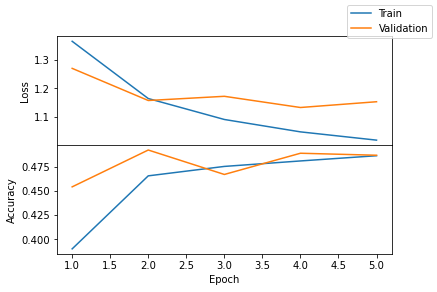

In [34]:
plot_acc(movies_cf_c_d_2_history);

In [35]:
Y_movies_cf_c_d_2_test = movies_cf_c_d_2.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_d_2_test = Y_movies_cf_c_d_2_test.argmax(axis=1)
Y_movies_cf_c_d_2_train = movies_cf_c_d_2.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_d_2_train = Y_movies_cf_c_d_2_train.argmax(axis=1)

In [36]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_d_2_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_d_2_train)

Test:
              precision    recall  f1-score   support

           0       0.07      0.46      0.12      1646
           1       0.13      0.45      0.20      4616
           2       0.50      0.42      0.46     42436
           3       0.67      0.44      0.53     77496
           4       0.51      0.68      0.58     34373

    accuracy                           0.49    160567
   macro avg       0.37      0.49      0.38    160567
weighted avg       0.57      0.49      0.51    160567

Train:
              precision    recall  f1-score   support

           0       0.11      0.68      0.19      4940
           1       0.16      0.57      0.26     13846
           2       0.54      0.46      0.49    127306
           3       0.70      0.47      0.56    232487
           4       0.53      0.72      0.61    103119

    accuracy                           0.52    481698
   macro avg       0.41      0.58      0.42    481698
weighted avg       0.60      0.52      0.54    481698



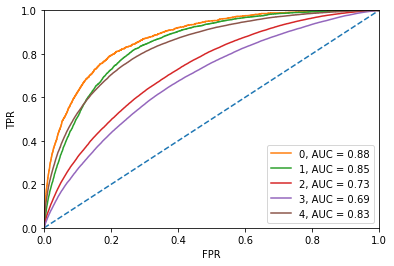

In [37]:
plot_rocc(y_test - 1, Y_movies_cf_c_d_2_test);

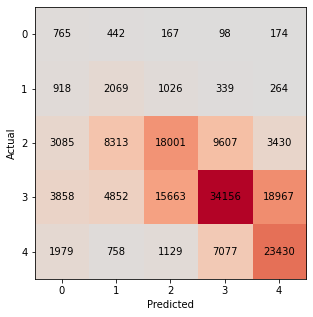

In [38]:
plot_confmat(y_test - 1, y_movies_cf_c_d_2_test);

In [39]:
print_rg_report(y_test - 1, y_movies_cf_c_d_2_test)

MSE = 1.203678215324444
MAE = 0.6948065293615749


## Variant 3

In [12]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(n_classes, 'softmax')
)
movies_cf_c_d_3 = Model([user_input, movie_input], user_movie, name='movies_cf_c_d_3')
movies_cf_c_d_3.summary()

Model: "movies_cf_c_d_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
____________________________________________________________________________________

In [13]:
movies_cf_c_d_3.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_d_3_hist = movies_cf_c_d_3.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 46s 15ms/step - loss: 1.0357 - accuracy: 0.5470 - val_loss: 0.9444 - val_accuracy: 0.5883
Epoch 2/8
3011/3011 [==============================] - 48s 16ms/step - loss: 0.8961 - accuracy: 0.6120 - val_loss: 0.9262 - val_accuracy: 0.5947
Epoch 3/8
3011/3011 [==============================] - 47s 16ms/step - loss: 0.8434 - accuracy: 0.6361 - val_loss: 0.9327 - val_accuracy: 0.5926
Epoch 4/8
3011/3011 [==============================] - 49s 16ms/step - loss: 0.7959 - accuracy: 0.6585 - val_loss: 0.9469 - val_accuracy: 0.5901
Epoch 5/8
3011/3011 [==============================] - 47s 16ms/step - loss: 0.7522 - accuracy: 0.6803 - val_loss: 0.9751 - val_accuracy: 0.5829


In [14]:
movies_cf_c_d_3.save('data/movies_cf_c_d_3.h5')
save(movies_cf_c_d_3_hist.history, 'data/movies_cf_c_d_3_history.pickle')

### Evalueren

In [15]:
movies_cf_c_d_3 = load_model('data/movies_cf_c_d_3.h5')
movies_cf_c_d_3_history = load('data/movies_cf_c_d_3_history.pickle')

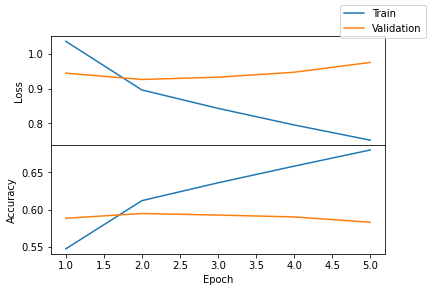

In [16]:
plot_acc(movies_cf_c_d_3_history);

In [17]:
Y_movies_cf_c_d_3_test = movies_cf_c_d_3.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_d_3_test = Y_movies_cf_c_d_3_test.argmax(axis=1)
Y_movies_cf_c_d_3_train = movies_cf_c_d_3.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_d_3_train = Y_movies_cf_c_d_3_train.argmax(axis=1)

In [18]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_d_3_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_d_3_train)

Test:
              precision    recall  f1-score   support

           0       0.29      0.04      0.07      1646
           1       0.27      0.04      0.06      4616
           2       0.56      0.49      0.52     42436
           3       0.61      0.74      0.67     77496
           4       0.61      0.50      0.55     34373

    accuracy                           0.59    160567
   macro avg       0.47      0.36      0.37    160567
weighted avg       0.58      0.59      0.58    160567

Train:
              precision    recall  f1-score   support

           0       0.55      0.08      0.15      4940
           1       0.49      0.08      0.13     13846
           2       0.63      0.55      0.59    127306
           3       0.65      0.79      0.71    232487
           4       0.67      0.55      0.61    103119

    accuracy                           0.65    481698
   macro avg       0.60      0.41      0.44    481698
weighted avg       0.64      0.65      0.63    481698



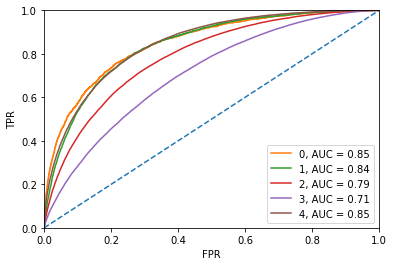

In [19]:
plot_rocc(y_test - 1, Y_movies_cf_c_d_3_test);

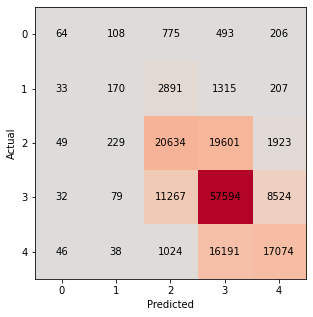

In [20]:
plot_confmat(y_test - 1, y_movies_cf_c_d_3_test);

In [21]:
print_rg_report(y_test - 1, y_movies_cf_c_d_3_test)

MSE = 0.5634158949223689
MAE = 0.4514750851669397
